In [499]:
import json
from pandas.io.json import json_normalize
import pandas
pandas.options.display.float_format = '{:,.1f}'.format

import numpy
# from sklearn.feature_extraction.text import DictVectorizer
from matplotlib import pyplot
from matplotlib.colors import Normalize, LogNorm
%matplotlib inline

from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn import linear_model
from sklearn import cross_validation
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor 

from sklearn.manifold import TSNE

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from nltk.stem import WordNetLemmatizer 

In [2]:
with open('/Users/regata/Downloads/properties.json', 'rt') as f:
    data = json.load(f)
    
data_arr = map(lambda x: data[x], data.keys())

In [3]:
# flatten json into dataframe
df = json_normalize(data_arr)
print(df.shape)
df.head(20).T

(6916, 98)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
% dif,118.0,102.0,104.0,93.0,99.0,108.0,108.0,98.0,99.0,125.0,93.0,95.0,102.0,113.0,95.0,99.0,108.0,100.0,105.0,110.0
address.city,toronto,georgina,toronto,toronto,brampton,markham,toronto,brampton,toronto,toronto,toronto,toronto,ajax,brock,brampton,mississauga,oakville,brampton,toronto,toronto
address.neighbourhood,dovercourt-wallace emerson-junction,keswick south,glenfield-jane heights,dorset park,credit valley,cornell,humberlea-pelmo park w5,fletcher's meadow,mount pleasant east,cliffcrest,malvern,scarborough village,south east,sunderland,queen street corridor,erindale,glen abbey,fletcher's west,high park-swansea,alderwood
address.postal code,M6H1W5,L4P4B3,M3L2A8,M1P4V3,L640Z2,L6B1G4,M9M0E3,L7A3L8,M4S 1A5,M1M2C5,M1B4Z3,M1M3T7,L1S7T3,L0C 1H0,L6S5K7,L5C2Z3,L6M1A6,L6Y4L3,M6S3E7,M8W 3T2
address.province,ontario,ontario,ontario,ontario,ontario,ontario,ontario,ontario,ontario,ontario,ontario,ontario,ontario,ontario,ontario,ontario,ontario,ontario,ontario,ontario
address.street,53 hallam st,36 glasgow cres,25 whitbread cres,301 prudential dr,30 kimborough hllw,16 northvale rd,29 betty nagle st,22 sugarhill dr,319 merton st,54 colonial ave,8 silverbell grve,91 muir dr,1 langsdorff dr,2175 concession 5 rd,22 hanover rd,830 stainton dr,1228 old post dr,149 torrance wood,99 durie st,138 browns line
apx age.label,NaN,6-15,NaN,31-50,0-5,6-15,0-5,NaN,6-10,NaN,6-15,NaN,NaN,NaN,16-30,NaN,31-50,NaN,NaN,31-50
apx age.val,NaN,15.0,NaN,50.0,5.0,15.0,5.0,NaN,10.0,NaN,15.0,NaN,NaN,NaN,30.0,NaN,50.0,NaN,NaN,50.0
apx sqft.label,1500-2000,1500-2000,NaN,800-899,1500-2000,NaN,NaN,NaN,600-699,NaN,1000-1199,1200-1399,NaN,1100-1500,1000-1199,1200-1399,2000-2500,3000-3500,NaN,NaN
apx sqft.val,"2,000.0","2,000.0",NaN,899.0,"2,000.0",NaN,NaN,NaN,699.0,NaN,"1,199.0","1,399.0",NaN,"1,500.0","1,199.0","1,399.0","2,500.0","3,500.0",NaN,NaN


In [140]:
# exclude any non-sale properties
df = df[df['detail.for'] == 'sale']

df['price_diff'] = df['sold'] - df['list']

# exclude rows with missing values
df = df[df['price_diff'].notnull()]
df = df[df['detail.client remks'].notnull()]

# exclude price outliers
df['price_ratio'] =  df['price_diff'] / df['list']
df = df[df['price_ratio'] < 1]

# exclude missing property_type
df = df[df['property_type'].notnull()]

df.shape

(6101, 103)

In [141]:
# fill missing values
# df['apx age.val'].fillna(0, inplace=True)
# df['apx sqft.val'].fillna(0, inplace=True)

df['bedrooms'] = df['bedrooms.val'] + df['bedrooms.plus']
# df['bedrooms'].fillna(0, inplace=True)

df['rooms'] = df['rms.val'] + df['rms.plus']
# df['rooms'].fillna(0, inplace=True)

df['kitchens'] = df['kitchens.val'] + df['kitchens.plus']
# df['kitchens'].fillna(0, inplace=True)

# df['washrooms'].fillna(0, inplace=True)

# df['maint'].fillna(0, inplace=True)
# df['taxes'].fillna(0, inplace=True)

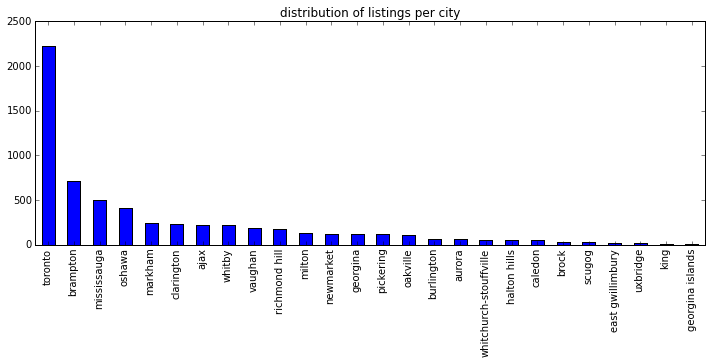

In [142]:
ax = df['address.city'].value_counts().plot(kind='bar', figsize=(12,4))
ax.set_title('distribution of listings per city')

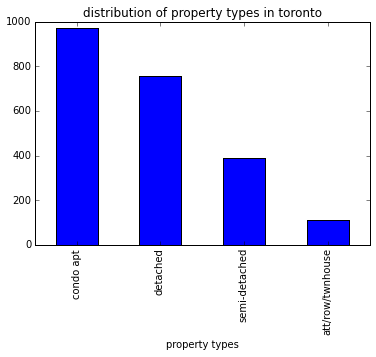

In [143]:
df_toronto = df[df['address.city'] == 'toronto']
ax = df_toronto['property_type'].value_counts().plot(kind='bar')
ax.set_xlabel('property types')
ax.set_title('distribution of property types in toronto')

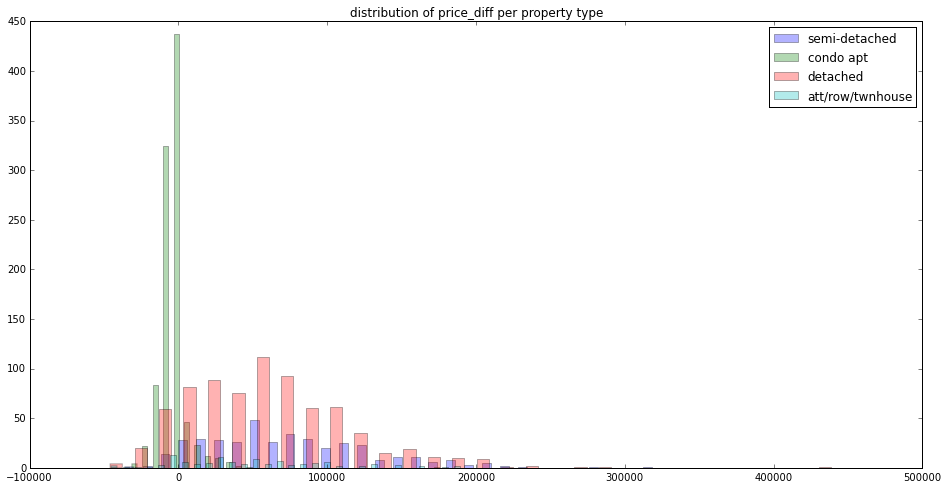

In [8]:
property_types = df_toronto['property_type'].unique()

fig = pyplot.figure(figsize=(16,8))
for pt in property_types:
    ratios = df_toronto[df_toronto['property_type'] == pt]['price_diff'].values
    counts, bins = numpy.histogram(ratios, bins=30)
    ax = pyplot.hist(ratios, bins, alpha=0.3, label=pt, rwidth=0.5)

pyplot.legend(loc='upper right')
pyplot.title('distribution of price_diff per property type')
pyplot.show()

In [9]:
condo_mask = df_toronto['property_type'] == 'condo apt'
condo_feature_names = ['bedrooms', 'rooms', 'kitchens', 'washrooms', 'maint', 'taxes', 'list', 'sold']
house_feature_names = ['property_type', 'bedrooms', 'rooms', 'kitchens', 'washrooms', 'taxes', 'list', 'sold']

condo_features_df = df_toronto[condo_mask][condo_feature_names]
print 'condo_features_df.shape ' + str(condo_features_df.shape)
house_features_df = df_toronto[~condo_mask][house_feature_names]
print 'house_features_df.shape ' + str(house_features_df.shape)

condo_features_df.shape (971, 8)
house_features_df.shape (1260, 8)


[u'att/row/twnhouse' u'detached' u'semi-detached']


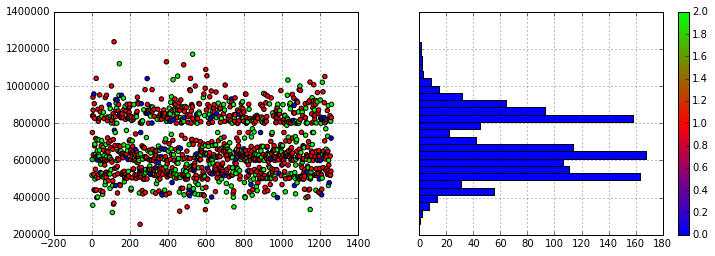

In [52]:
mask = ~condo_mask
data = df_toronto[mask]['sold'].values
marker = df_toronto[mask]['property_type']
le = LabelEncoder()
le.fit(marker.unique())
print le.classes_
marker = le.transform(marker)

f, (ax1, ax2) = pyplot.subplots(1, 2, sharey=True, figsize=(12, 4))
sc = ax1.scatter(xrange(len(data)), data, c=marker, cmap=pyplot.cm.brg, norm=pyplot.Normalize())
ax2.hist(data, bins=25, orientation='horizontal')
ax1.grid(), ax2.grid()
f.colorbar(sc)
pyplot.show()

In [11]:
condo_features_stats_df = condo_features_df.describe()
condo_features_stats_df

,bedrooms,rooms,kitchens,washrooms,maint,taxes,list,sold
count,971.0,971.0,971.0,971.0,971.0,971.0,971.0,971.0
mean,1.9,5.0,1.0,1.4,517.7,"1,592.1","288,162.4","283,834.3"
std,0.7,1.1,0.0,0.5,159.4,725.6,"96,705.2","97,446.2"
min,0.0,1.0,1.0,1.0,0.0,0.0,"48,900.0","40,000.0"
25%,1.0,4.0,1.0,1.0,401.9,"1,096.7","209,900.0","205,000.0"
50%,2.0,5.0,1.0,1.0,506.7,"1,457.0","263,900.0","263,000.0"
75%,2.0,6.0,1.0,2.0,624.6,"2,235.9","379,000.0","373,625.0"
max,4.0,9.0,1.0,4.0,"1,076.3","5,100.0","429,900.0","535,800.0"


##### house_features_stats_df = house_features_df.describe()
house_features_stats_df

In [13]:
# 'apx age.val', 'maint', 'taxes' has missing values

In [14]:
# # normalize features
# def normalize_features_and_fill_na(features, stats):
#     for col in features.columns:
#         if features[col].dtype == numpy.dtype('O'):
#             continue
#         mean = stats[col]['mean']
#         std = stats[col]['std']
#         features.loc[:, col] = (features[col] - mean) / std
#         features[col].fillna(0.0, inplace=True)
#     # 'taxes' has values 1
#     missing_taxes = (features['taxes'] < 100.0) | (features['taxes'].isnull())
#     features.loc[missing_taxes, 'taxes'] = 0.0
        
# normalize_features_and_fill_na(condo_features_df, condo_features_stats_df)
# normalize_features_and_fill_na(house_features_df, house_features_stats_df)

In [15]:
# fix missing 'taxes'
# http://www1.toronto.ca/wps/portal/contentonly?vgnextoid=6245ff0e43db1410VgnVCM10000071d60f89RCRD
# tax_rate = 0.7056037 / 100
# missing_taxes = (features_df['taxes'] < 100.0) | (features_df['taxes'].isnull())
# features_df.loc[missing_taxes, 'taxes'] = features_df[missing_taxes]['list'] * tax_rate

In [504]:
features_df = house_features_df
# features_df = condo_features_df
dict_vectorizer = DictVectorizer(dtype=float, sparse=False)

sold_prices = features_df['sold'].values
list_prices = features_df['list'].values
mean_sold_error = numpy.mean(sold_prices - list_prices)
naive_predictor = numpy.divide((sold_prices - list_prices - mean_sold_error), list_prices) * 100

Y = features_df['sold'].values
features_df = features_df.drop('sold', axis=1)
features_as_list = features_df.to_dict(orient='records')
X = dict_vectorizer.fit_transform(features_as_list)
print('X.shape', X.shape)
print('Y.shape', Y.shape)

idx = numpy.array(xrange(X.shape[0]), dtype=int)

X_train, X_test, y_train, y_test, idx_train, idx_test = \
    cross_validation.train_test_split(X, Y, idx, test_size=0.1, random_state=0)
# dict_vectorizer.get_feature_names()

clf = BaggingRegressor()
# clf = linear_model.LinearRegression(fit_intercept=True, normalize=False)
clf.fit (X_train, y_train)
y_pred = clf.predict(X_test)

error_perc = (y_test - y_pred) / y_test * 100
score = clf.score(X_test, y_test)

print 'naive predictor error'
print('mean', numpy.average(naive_predictor))
print('std', numpy.std(naive_predictor))

print 'classifier error'
print('score', score)
print('mean', numpy.average(error_perc))
print('std', numpy.std(error_perc))

('X.shape', (1260, 9))
('Y.shape', (1260,))
naive predictor error
('mean', -0.43481196878618955)
('std', 8.8902657558376994)
classifier error
('score', 0.88455258452428798)
('mean', -0.82619047921512623)
('std', 6.9538272770907534)


In [497]:
print sorted(zip(dict_vectorizer.get_feature_names(), clf.feature_importances_), key=lambda x: x[1])

[(u'property_type=att/row/twnhouse', 0.00043330792425347526), (u'property_type=detached', 0.0004866605029659287), ('kitchens', 0.0010552640861237863), (u'property_type=semi-detached', 0.0026203597521445069), ('bedrooms', 0.002804012162537583), ('rooms', 0.0036744464868580739), (u'washrooms', 0.0051559464368572637), (u'taxes', 0.030859758048106915), (u'list', 0.95291024460015239)]


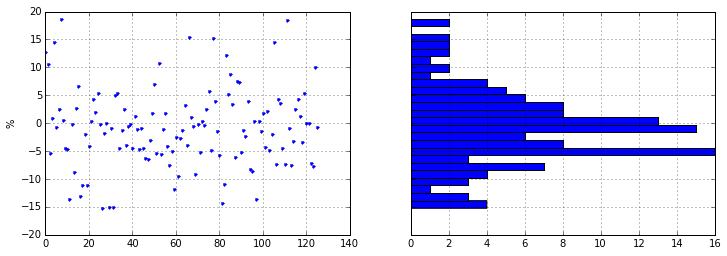

In [505]:
data = error_perc
f, (ax1, ax2) = pyplot.subplots(1, 2, sharey=True, figsize=(12, 4))
ax1.plot(data, linestyle='', marker='.')
ax2.hist(data, bins=25, orientation='horizontal')
ax1.set_ylabel('%')
ax1.grid(), ax2.grid()
pyplot.show()

In [18]:
# most error
top_error_idx = numpy.argsort(-numpy.abs(error_perc))
test_listing_ids = features_df.index[idx_test[top_error_idx]]
df_toronto.loc[test_listing_ids][house_feature_names + ['price_ratio']].head(15)

,property_type,bedrooms,rooms,kitchens,washrooms,taxes,list,sold,price_ratio
1890,condo apt,2.0,5.0,1.0,1,247.0,49900,"40,000.0",-0.2
2417,condo apt,3.0,6.0,1.0,2,"1,098.7",225000,"197,000.0",-0.1
1688,condo apt,2.0,5.0,1.0,1,965.4,48900,"48,900.0",0.0
5603,condo apt,2.0,5.0,1.0,1,"1,035.0",179900,"191,000.0",0.1
4065,condo apt,2.0,5.0,1.0,1,831.5,154900,"140,000.0",-0.1
1864,condo apt,2.0,5.0,1.0,1,"1,142.4",209000,"190,800.0",-0.1
4744,condo apt,3.0,6.0,1.0,1,906.3,159900,"169,000.0",0.1
2524,condo apt,1.0,1.0,1.0,1,"2,212.4",350000,"368,000.0",0.1
1879,condo apt,2.0,5.0,1.0,1,831.5,119900,"109,000.0",-0.1
2081,condo apt,2.0,5.0,1.0,2,959.4,104990,"105,000.0",0.0


In [19]:
# least error
df_toronto.loc[test_listing_ids][house_feature_names + ['price_ratio']].tail(15)

,property_type,bedrooms,rooms,kitchens,washrooms,taxes,list,sold,price_ratio
6819,condo apt,2.0,5.0,1.0,1,"1,135.1",209900,"207,000.0",-0.0
3155,condo apt,2.0,5.0,1.0,2,1.0,385900,"380,000.0",-0.0
4950,condo apt,3.0,7.0,1.0,2,"2,208.0",365800,"361,000.0",-0.0
1684,condo apt,2.0,4.0,1.0,2,0.0,383800,"377,800.0",-0.0
204,condo apt,2.0,5.0,1.0,1,"2,328.1",369000,"367,000.0",-0.0
2813,condo apt,2.0,5.0,1.0,1,860.0,129000,"125,000.0",-0.0
5647,condo apt,2.0,8.0,1.0,2,"2,042.6",388888,"387,000.0",-0.0
5487,condo apt,2.0,6.0,1.0,1,"1,278.9",242500,"240,000.0",-0.0
1962,condo apt,1.0,4.0,1.0,1,"2,266.6",389900,"387,000.0",-0.0
6138,condo apt,2.0,6.0,1.0,2,"2,096.7",359900,"356,000.0",-0.0


In [20]:
# http://mrloft.ca/Toronto-MLS-district-Map
# Google maps
# https://www.wakari.io/sharing/bundle/wakari_demo/realtime_twitter_analysis?has_login=False
# http://stackoverflow.com/questions/11761738/how-can-i-make-a-google-maps-api-v3-hexagon-tiled-map-preferably-coordinate-bas
# http://econym.org.uk/gmap/example_eshapes.html
# http://www.machinalis.com/blog/embedding-interactive-maps-into-an-ipython-nb/
# http://scikit-learn.org/stable/modules/feature_extraction.html
# http://blog.applied.ai/visualising-high-dimensional-data/
# https://github.com/dfm/triangle.py

In [75]:
X = condo_features_df.copy()
# X = house_features_df.copy()
# le = LabelEncoder()
# le.fit(X['property_type'].unique())
# X['property_type'] = le.transform(X['property_type'])
tsne = TSNE(n_components=2, random_state=0)
X_proj = tsne.fit_transform(X.values)

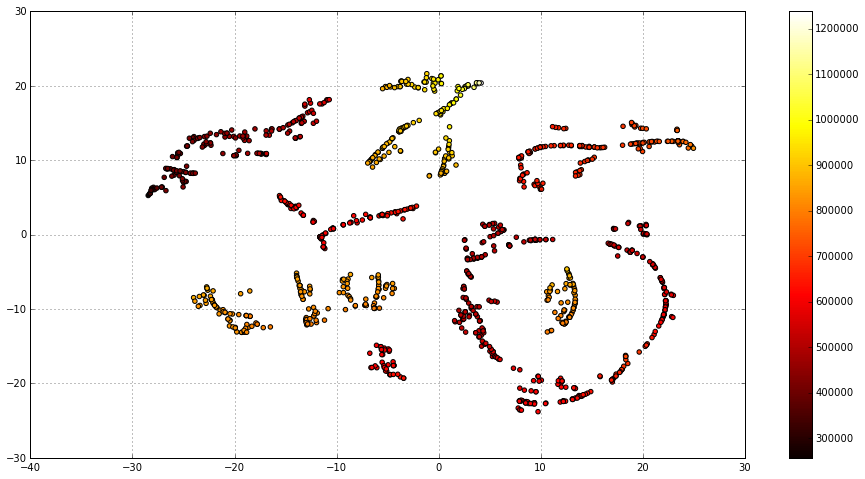

In [74]:
Y = df_toronto.loc[X.index]['sold']

fig = pyplot.figure(figsize=(16,8))
sc = pyplot.scatter(X_proj[:,0], X_proj[:,1], c=Y, cmap=pyplot.cm.hot, norm=Normalize())
pyplot.grid()
pyplot.colorbar(sc)
pyplot.show()


In [325]:
# http://radimrehurek.com/gensim/tut1.html#from-strings-to-vectors
# http://radimrehurek.com/topic_modeling_tutorial/2%20-%20Topic%20Modeling.html
lmtzr = WordNetLemmatizer()

specific_stopwords = 'live buyer flr ft rm bdrm hr pc sf sq toronto st scarborough \
                        city master door perfect beautiful bsmt \
                        south north west east'.split()
stopwords = list(STOPWORDS) + specific_stopwords
def tokenize(text):
    return [lmtzr.lemmatize(token) for token in simple_preprocess(text) if token not in stopwords]
    # return [token for token in simple_preprocess(text)]

raw_docs = df_toronto[condo_mask]['detail.client remks']
doc_stream = map(lambda doc: tokenize(doc), raw_docs)

dictionary = Dictionary(doc_stream)
print(dictionary)
dictionary.filter_extremes(no_below=20, no_above=0.3)
# dictionary.filter_extremes(no_below=5)
dictionary.compactify()
print(dictionary)

Dictionary(2878 unique tokens: [u'cresford', u'sunsplashed', u'desirable', u'yellow', u'sleek']...)
Dictionary(337 unique tokens: [u'shop', u'approx', u'concept', u'golf', u'need']...)


In [335]:
corpus = map(lambda doc: dictionary.doc2bow(doc), doc_stream)
lda_model = LdaModel(corpus, num_topics=7, id2word=dictionary, passes=40, alpha=0.1)

In [336]:
lda_model.show_topics(num_words=7)

[u'0.029*school + 0.028*close + 0.026*location + 0.022*great + 0.021*subway + 0.020*shopping + 0.019*large',
 u'0.032*location + 0.025*centre + 0.025*transit + 0.025*shopping + 0.025*building + 0.024*step + 0.023*golf',
 u'0.080*new + 0.031*light + 0.024*brand + 0.022*counter + 0.019*granite + 0.016*laminate + 0.015*upgrade',
 u'0.031*large + 0.027*open + 0.025*living + 0.025*ceiling + 0.023*closet + 0.022*concept + 0.018*window',
 u'0.031*pool + 0.024*park + 0.022*court + 0.021*tennis + 0.019*great + 0.019*security + 0.018*gym',
 u'0.045*pool + 0.041*party + 0.038*concierge + 0.033*indoor + 0.032*gym + 0.029*suite + 0.025*sauna',
 u'0.034*den + 0.027*district + 0.026*ceiling + 0.025*lake + 0.025*step + 0.021*centre + 0.020*restaurant']

In [507]:
doc = raw_docs.iloc[3]
print doc + '\n'
tokenized = tokenize(doc)
doc_bow = dictionary.doc2bow(tokenized)
topics = lda_model[doc_bow]
for t in topics:
    print t
    print lda_model.print_topic(t[0]) + '\n'


absolutely gorgeous *totally renovated* unit w/ spacious layout in high demand family friendly complex! modern kitchen boasting stainless steel appliances - custom backsplash - granite floors & maple cabinetry, plenty of windows & sunlight everywhere! beautifully painted throughout, overlooks greenspace & undisturbed ravine, close to all amenities, perfect for investors (renters pending!) or 1st time buyers, very low condo fee, pack before you call!

(0, 0.45220748521952076)
0.029*school + 0.028*close + 0.026*location + 0.022*great + 0.021*subway + 0.020*shopping + 0.019*large + 0.018*bright + 0.017*building + 0.016*maintained

(3, 0.52906284057313591)
0.031*large + 0.027*open + 0.025*living + 0.025*ceiling + 0.023*closet + 0.022*concept + 0.018*window + 0.015*counter + 0.015*granite + 0.014*space

